# Non-ideal equations of state

This example demonstrates a comparison between ideal and non-ideal equations of state (EoS) using Cantera and CoolProp.

The following equations of state are used to evaluate thermodynamic properties in this example:

1. Ideal-gas EoS from Cantera
2. Non-ideal Redlich-Kwong EoS (R-K EoS) from Cantera
3. Helmholtz energy EoS (HEOS) from CoolProp

#### Import required packages (Cantera and CoolProp)
[CoolProp](http://coolprop.org) [1] is an open-source package that contains a highly-accurate database for thermophysical properties. The thermodynamic properties are obtained using pure and pseudo-pure fluid equations of state implemented for 122 components.

> 1. I.H. Bell, J.Wronski, S. Quoilin, V. Lemort, 'Pure and Pseudo-pure Fluid Thermophysical Property Evaluation and the Open-Source Thermophysical Property Library CoolProp,' Industrial & Engineering Chemistry Research 53 (2014), https://pubs.acs.org/doi/10.1021/ie4033999

If you are using `conda` to manage your software environment, activate your cantera environment and install coolprop via:

```
conda install -c conda-forge coolprop
```

In [1]:
import cantera as ct
import numpy as np
from CoolProp.CoolProp import PropsSI

%matplotlib inline
%config InlineBackend.figure_formats = ["svg"]
import matplotlib.pyplot as plt

plt.rcParams["figure.dpi"] = 120

print(f"Running Cantera version: {ct.__version__}")

Running Cantera version: 2.6.0


### Helper functions
This example uses CO$_2$ as the only species. The function `get_thermo_Cantera` calculates thermodynamic properties based on the thermodynamic state ($T$, $p$) of the species using Cantera. Applicable phases are `Ideal-gas` and `Redlich-Kwong`. The ideal-gas equation can be stated as
\begin{equation}
    pv = RT,
\end{equation}
where $p$, $v$ and $T$ represent thermodynamic pressure, molar volume, and the temperature of the gas-phase. $R$ is the universal gas constant. The Redlich-Kwong equation is a cubic, non-ideal equation of state, represented as
\begin{equation}
    p=\frac{RT}{v-b^\ast}-\frac{a^\ast}{v\sqrt{T}(v+b^\ast)}.
\end{equation}
In this expression, $R$ is the universal gas constant and $v$ is the molar volume. The temperature-dependent van der Waals attraction parameter $a^\ast$ and volume correction parameter (repulsive parameter) $b^\ast$ represent molecular interactions.

The function `get_thermo_CoolProp` utilizes the CoolProp package to evaluate thermodynamic properties based on the thermodynamic state ($T$, $p$) for a given fluid. The HEOS for CO$_2$ used in this example is obtained from http://www.coolprop.org/fluid_properties/fluids/CarbonDioxide.html.

Since the standard-reference thermodynamic states are different for Cantera and CoolProp, it is necessary to convert these values to an appropriate scale before comparison. Therefore, both functions `get_thermo_Cantera` and `get_thermo_CoolProp` return the thermodynamic values relative to a reference state at 1 bar, 300 K.

To plot the comparison of thermodynamic properties among the three EoS, the `plot` function is used. 

In [2]:
def get_thermo_Cantera(phase, T, p):

    states = ct.SolutionArray(phase, len(p))
    X = "CO2:1.0"
    states.TPX = T, p, X

    u = states.u / 1000
    h = states.h / 1000
    s = states.s / 1000
    cp = states.cp / 1000
    cv = states.cv / 1000

    # Get the relative enthalpy, entropy and int. energy with reference to the first point
    u = u - u[0]
    s = s - s[0]
    h = h - h[0]

    return h, u, s, cp, cv


def get_thermo_CoolProp(T, p):

    u = np.zeros_like(p)
    h = np.zeros_like(p)
    s = np.zeros_like(p)
    cp = np.zeros_like(p)
    cv = np.zeros_like(p)

    for i in range(p.shape[0]):

        u[i] = PropsSI("U", "P", p[i], "T", T, "CO2")
        h[i] = PropsSI("H", "P", p[i], "T", T, "CO2")
        s[i] = PropsSI("S", "P", p[i], "T", T, "CO2")
        cp[i] = PropsSI("C", "P", p[i], "T", T, "CO2")
        cv[i] = PropsSI("O", "P", p[i], "T", T, "CO2")

    # Get the relative enthalpy, entropy and int. energy with reference to the first point
    u = (u - u[0]) / 1000
    s = (s - s[0]) / 1000
    h = (h - h[0]) / 1000
    cp = cp / 1000
    cv = cv / 1000

    return h, u, s, cp, cv


def plot(p, thermo_Ideal, thermo_RK, thermo_CoolProp, name):

    line_width = 3

    fig, ax = plt.subplots()
    ax.plot(
        p / 1e5, thermo_Ideal, "-", color="b", linewidth=line_width, label="Ideal EoS"
    )
    ax.plot(p / 1e5, thermo_RK, "-", color="r", linewidth=line_width, label="R-K EoS")
    ax.plot(
        p / 1e5, thermo_CoolProp, "-", color="k", linewidth=line_width, label="CoolProp"
    )
    ax.set_xlabel("Pressure [bar]")
    ax.set_ylabel(name)
    ax.legend(prop={"size": 14}, frameon=False)

## 1. EoS Comparison based on thermodynamic properties 

This is the main subroutine that compares and plots the thermodynamic values obtained using three equations of state. 

In [3]:
# Input parameters
T = 300  # Temperature is constant [unit: K]
p = 1e5 * np.linspace(1, 100, 1000)  # Pressure is varied from 1 to 100 bar [unit: Pa]

# Read the ideal-gas phase
ideal_gas_phase = ct.Solution("../data/co2-thermo.yaml", "CO2-Ideal", transport=None)
h_ideal, u_ideal, s_ideal, cp_ideal, cv_ideal = get_thermo_Cantera(
    ideal_gas_phase, T, p
)

# Read the Redlich-Kwong phase
redlich_kwong_phase = ct.Solution("../data/co2-thermo.yaml", "CO2-RK", transport=None)
h_RK, u_RK, s_RK, cp_RK, cv_RK = get_thermo_Cantera(redlich_kwong_phase, T, p)

# Read the thermo data using CoolProp
h_CoolProp, u_CoolProp, s_CoolProp, cp_CoolProp, cv_CoolProp = get_thermo_CoolProp(T, p)

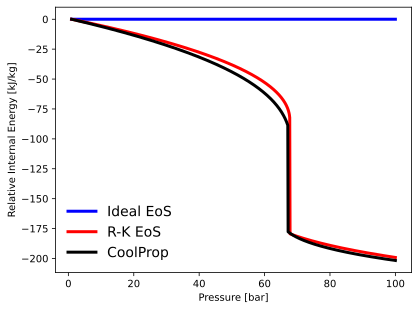

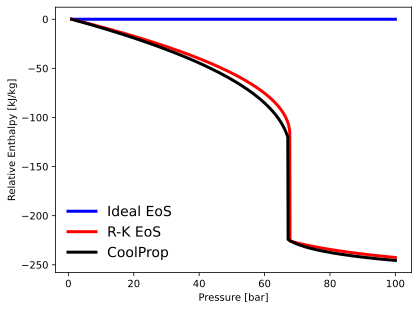

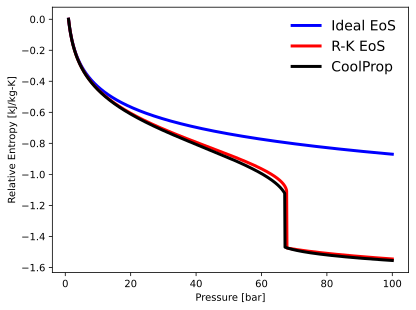

In [4]:
# Plot the results
plot(p, u_ideal, u_RK, u_CoolProp, "Relative Internal Energy [kJ/kg]")
plot(p, h_ideal, h_RK, h_CoolProp, "Relative Enthalpy [kJ/kg]")
plot(p, s_ideal, s_RK, s_CoolProp, "Relative Entropy [kJ/kg-K]")

The thermodynamic properties such as internal energy, enthalpy, and entropy are plotted against the operating pressure at a constant temperature $T = 300$ K. The three equations follow each other closely at low pressures ($P < 10$ bar). However, the ideal gas EoS departs significantly from the observed behavior of gases near the critical regime ($P_{\rm {crit}} = 73.77$ bar).

The ideal gas EoS does not consider inter-molecular interactions and the volume occupied by individual gas particles. At low temperatures and high pressures, inter-molecular forces become particularly significant due to a reduction in inter-molecular distances. Additionally, at high density, the volume of individual molecules becomes significant. Both of these factors contribute to the deviation from ideal behavior at high pressures. The cubic Redlich-Kwong EoS, on the other hand, predicts thermodynamic properties accurately near the critical regime. 

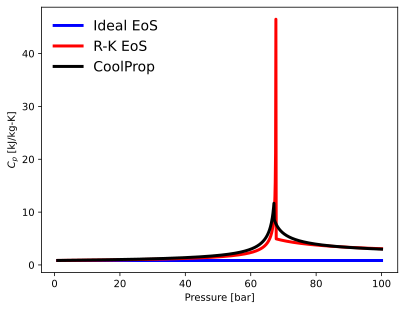

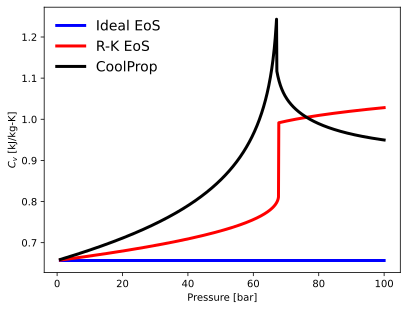

In [5]:
# Specific heat at constant pressure
plot(p, cp_ideal, cp_RK, cp_CoolProp, "$C_p$ [kJ/kg-K]")
# Specific heat at constant volume
plot(p, cv_ideal, cv_RK, cv_CoolProp, "$C_v$ [kJ/kg-K]")

In the case of Ideal gas EoS, the specific heats at constant pressure ($C_{\rm p}$) and constant volume ($C_{\rm v}$) are independent of the pressure. Hence, $C_{\rm p}$ and $C_{\rm v}$ for ideal EoS do not change as the pressure is varied from $1$ bar to $100$ bar in this study.

$C_{\rm p}$ for the R-K EoS follows the trend closely with the Helmholtz EoS from CoolProp up to the critical regime. Although $C_{\rm p}$ shows reasonable agreement with the Helmholtz EoS in sub-critical and supercritical regimes, it inaccurately predicts a very high value near the critical point. However, $C_{\rm p}$ at the critical point is finite for the real fluid. The sudden rise in $C_{\rm p}$ in the case of the R-K EoS is just a numerical artifact, due to the EoS yielding infinite values in the limiting case, and not a real singularity. 

$C_{\rm v}$, on the other hand, predicts smaller values in the subcritical and critical regime. However, it shows completely incorrect values in the super-critical region, making it invalid at very high pressures. It is well known that the cubic equations typically fail to predict accurate constant-volume heat capacity in the transcritical region [2]. Certain cubic EoS models have been extended to resolve this discrepancy using crossover models. For further information, see the work of Span [2] and Saeed et al. [3].

> 2. R. Span, 'Multiparameter Equations of State - An Accurate Source of Thermodynamic Property Data', Springer Berlin Heidelberg (2000), https://dx.doi.org/10.1007/978-3-662-04092-8
> 3. A. Saeed, S. Ghader, 'Calculation of density, vapor pressure and heat capacity near the critical point by incorporating cubic SRK EoS and crossover translation', Fluid Phase Equilibria (2019) 493, https://doi.org/10.1016/j.fluid.2019.03.027

## 2. Temperature-Density plots

The following function plots the $T$-$\rho$ diagram over a wide pressure and temperature range. The temperature is varied from 250 K to 400 K. The pressure is changed from 1 bar to 600 bar.

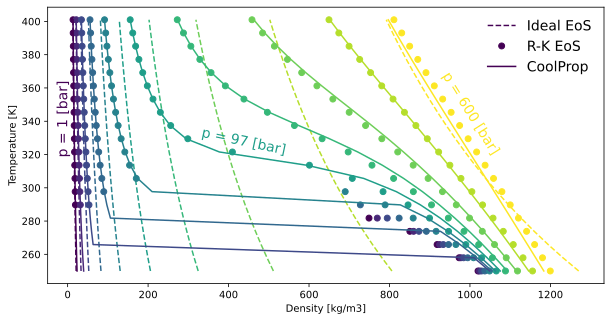

In [20]:
# Input parameters
# Set up arrays for pressure and temperature
p_array = np.logspace(1, np.log10(600), 10, endpoint=True)
T_array = np.linspace(250, 401, 20)  # Temperature is varied from 250K to 400K
p_array = 1e5 * np.array(p_array)[:, np.newaxis]

# Calculate densities for Ideal gas and R-K EoS phases
states = ct.SolutionArray(ideal_gas_phase, shape=(p_array.size, T_array.size))
states.TP = T_array, p_array
density_ideal = states.density_mass

states = ct.SolutionArray(redlich_kwong_phase, shape=(p_array.size, T_array.size))
states.TP = T_array, p_array
density_RK = states.density_mass

p, T = np.meshgrid(p_array, T_array)#, -1).reshape(-1, 2)
density_coolprop = PropsSI("D", "P", p, "T", T, "CO2")

# Plot
import cycler
color = plt.cm.viridis(np.linspace(0, 1, p_array.size))
plt.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)

fig, ax = plt.subplots(figsize=(10, 5))
ideal_line = ax.plot(density_ideal.T, T_array, "--", label="Ideal EoS")
RK_line = ax.plot(density_RK.T, T_array, "o", label="R-K EoS")
CP_line = ax.plot(density_coolprop, T_array, "-", label="CoolProp")
ax.text(-27.5, 320, "p = 1 [bar]", color=color[0], rotation="vertical", size="14")
ax.text(330, 320, "p = 97 [bar]", color=color[5], size="14", rotation="-12")
ax.text(925, 320, "p = 600 [bar]", color=color[9], size="14", rotation="-58")
ax.set_xlabel("Density [kg/m3]")
ax.set_ylabel("Temperature [K]")
ax.legend(handles=[ideal_line[0], RK_line[0], CP_line[0]], prop={"size": 14}, frameon=False);

The figure compares $T-\rho$ plots for ideal, R-K, and Helmholtz EoS at different operating pressures. All three EoS yield the same plots at low pressures (0 bar and 10 bar). However, the Ideal gas EoS departs significantly at high pressures ($P > 10$ bar), where non-ideal effects are prominent. The R-K EoS closely matches the Helmholtz EoS at supercritical pressures ($P \ge 70$ bar). However, it does depart in the liquid-vapor region that exists at $P < P_{\rm {crit}}$ and low temperatures (~$T_{\rm {crit}}$).